In [1]:
import sys
import os
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
# Add parent directory to sys.path
sys.path.insert(0, parent_dir)
# Now you can import the module

import gptransform
import torch
import matplotlib.pyplot as plt
from pickle import dump,load
import time
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.distributions.multivariate_normal import  MultivariateNormal
from scipy import interpolate

In [2]:
class data(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    if len(self.X) != len(self.Y):
      raise Exception("len(X) != len(Y)")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    _x = self.X[index].unsqueeze(dim=0)
    _y = self.Y[index].unsqueeze(dim=0)

    return _x, _y

def train_loop(dataloader, model, optimizer, totalEpochs, r_grid, q_train, sq_train, q_infer, r_infer, ylo_q, yhi_q, ylo_r, yhi_r):
    model.train()
    optimizer.zero_grad()
    losses = []
    tic = time.time()
    for epoch in range(totalEpochs):
        epoch_loss = 0
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss
            loss = model.NEG_LMLH_Monte_Carlo(r_grid, X[0], y[0])
                
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.detach().item()

        losses.append(epoch_loss)
            
        if epoch % 10 == 0:
            toc = time.time()
            print(f"loss: {epoch_loss:>7f}  [{epoch:>5d}/{totalEpochs:>5d}]")
            model.print_params()
            print(f"Minutes Taken Since Last Report: {(toc - tic)/60:>4f} ")
            print()

            with torch.no_grad():

                plt.title("S(q) Prediction")
                μ_q, Σ_q = model.predict_sq_monte_carlo(r_grid, q_infer, q_train, sq_train,False)
                plt.scatter(q_train,sq_train,alpha=0.2,label="Presented Data")
                plt.plot(q_infer.detach().numpy(),μ_q.detach().numpy(),label="Mean Prediction")
                plt.fill_between(q_infer.T[0].detach().numpy(), μ_q.T[0].detach().numpy()+torch.diag(Σ_q).detach().numpy()**0.5, μ_q.T[0].detach().numpy()-torch.diag(Σ_q).detach().numpy()**0.5,alpha=0.5,label="1 +- std")
                plt.ylim(ylo_q,yhi_q)
                plt.xlim(q_infer[0],q_infer[-1])
                plt.legend()
                plt.show()
            
            tic = time.time()

    return losses

In [3]:
init_param_bounds = torch.zeros((17,2))

# Ell
init_param_bounds[0,1] = 2.5
init_param_bounds[0,0] = 0.1

# Max
init_param_bounds[1,1] = 2
init_param_bounds[1,0] = 0.2

# Slope
init_param_bounds[2,1] = 10
init_param_bounds[2,0] = 1

# Loc
init_param_bounds[3,1] = 6
init_param_bounds[3,0] = 2

# Decay
init_param_bounds[4,1] = 1
init_param_bounds[4,0] = 0.1

# Sigma_n
init_param_bounds[5,1] = 0.05
init_param_bounds[5,0] = 0.0001

# r_0
init_param_bounds[6,1] = 6
init_param_bounds[6,0] = 0.5

# s
init_param_bounds[7,1] = 50
init_param_bounds[7,0] = 2

# - Bonded

# h_1
init_param_bounds[8,1] = 5
init_param_bounds[8,0] = 0.01

# r_1
init_param_bounds[9,1] = 1.45
init_param_bounds[9,0] = 1.25

# s_1
init_param_bounds[10,1] = 0.2
init_param_bounds[10,0] = 0.0001


# h_2
init_param_bounds[11,1] = 5
init_param_bounds[11,0] = 0.01

# r_2
init_param_bounds[12,1] = 2.5
init_param_bounds[12,0] = 2.3

# s_2
init_param_bounds[13,1] = 0.2
init_param_bounds[13,0] = 0.01


# h_3
init_param_bounds[14,1] = 5
init_param_bounds[14,0] = 0.01

# r_3
init_param_bounds[15,1] = 2.85
init_param_bounds[15,0] = 2.6

# s_3
init_param_bounds[16,1] = 0.2
init_param_bounds[16,0] = 0.01


#init_params = torch.sum(init_param_bounds,dim=1)/2

init_params =  torch.tensor([0.495561, 1.332820, 6.645961, 2.310010, 0.528412, 0.043205, 
                2.934750, 25.270943, 0.946981, 1.323820, 0.129564, 1.185353, 2.365046, 0.140710, 1.106304, 2.750376, 0.126561])

init_params = torch.tensor([0.110998, 0.3, 7.352607, 3, 0.570625, 0.021052, 2.848925, 26.418085, 0.583383, 1.291556, 0.172633, 
0.586859, 2.335970, 0.174507, 0.223117,  2.728037,  0.151851])

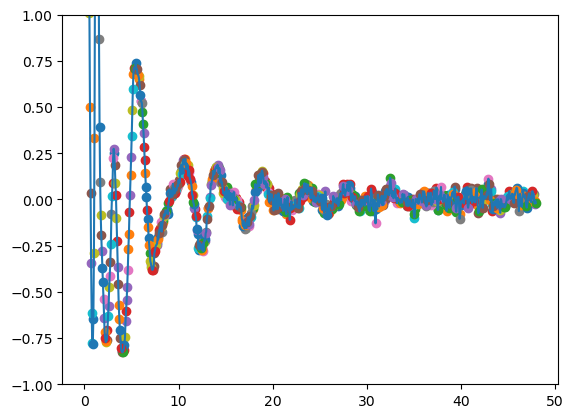

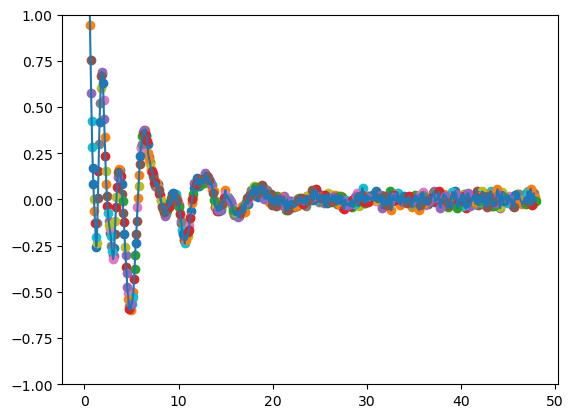

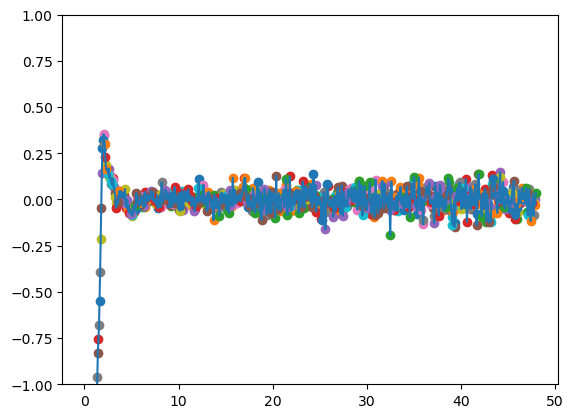

In [4]:
b_c = 6.6460         # Carbon Coherent Scattering Length [Femtometer]
b_h = -3.7390        # Hydrogen Coherent Scattering Length [Femtometer]
b_d = 6.671          # Duterium Coherent Scattering Length[Femtometer]
b_hd = (b_h + b_d)/2 # Half Duterium Half Hydrogen Coherent Scattering Length[Femtometer]

c_c = 1/2 # Atomic Fraction C
c_h = 1/2 # Atomic Fraction H

σCC = (2 - 1)*c_c*c_c*b_c*b_c 
σCH = (2    )*c_c*c_h*b_c*b_h
σHH = (2 - 1)*c_h*c_h*b_h*b_h

σCC1 = (2 - 1)*c_c*c_c*b_c*b_c
σCHD = (2    )*c_c*c_h*b_c*b_hd
σHD =  (2 - 1)*c_h*c_h*b_hd*b_hd

σCC2 = (2 - 1)*c_c*c_c*b_c*b_c
σCD  = (2    )*c_c*c_h*b_c*b_d
σDD  = (2 - 1)*c_h*c_h*b_d*b_d

M = torch.tensor([[σCC, σCH , σHH],
              [σCC1, σCHD, σHD],
              [σCC2, σCD , σDD]])

M_inv = torch.linalg.inv(M)

r_grid = torch.linspace(0.0001, 50, 8000).reshape(-1,1)
every = 2
ditch = 18+16
start = 1
my_data = np.genfromtxt("c6h6.mint01", skip_header=14)#[::2]
q_hh = torch.unsqueeze(torch.tensor(my_data.T[0][::every]),dim=1)[start:-ditch]
sq_HH = torch.unsqueeze(torch.tensor(my_data.T[1][::every]),dim=1)[start:-ditch]

my_data = np.genfromtxt("c6d6.mint01", skip_header=14)#[::2]
q_dd = torch.unsqueeze(torch.tensor(my_data.T[0][::every]),dim=1)[start:-ditch]
sq_DD = torch.unsqueeze(torch.tensor(my_data.T[1][::every]),dim=1)[start:-ditch]

my_data = np.genfromtxt("c6h6_c6d6.mint01", skip_header=14)#[::2]
q_hd = torch.unsqueeze(torch.tensor(my_data.T[0][::every]),dim=1)[start:-ditch]
sq_HD = torch.unsqueeze(torch.tensor(my_data.T[1][::every]),dim=1)[start:-ditch]

tck = interpolate.splrep(q_hd.T[0], sq_HD.T[0])
sq_HD = torch.unsqueeze(torch.tensor(interpolate.splev(q_hh.T[0], tck)),dim=1)
tck = interpolate.splrep(q_dd.T[0], sq_DD.T[0])
sq_DD = torch.unsqueeze(torch.tensor(interpolate.splev(q_hh.T[0], tck)),dim=1)

q_train = q_hh
q_infer = q_hh
r_infer = torch.linspace(0.0001, 20, 400).reshape(-1,1)

structure_total_q_noisey = torch.zeros((3,len(q_train)))
structure_total_q_noisey[0] = sq_HH.T[0]
structure_total_q_noisey[1] = sq_HD.T[0]
structure_total_q_noisey[2] = sq_DD.T[0]
structure_partial_q_noisey = 100*(M_inv @ structure_total_q_noisey)

partial_sq_noisey_CC = structure_partial_q_noisey[0].reshape(-1,1)
partial_sq_noisey_CH = structure_partial_q_noisey[1].reshape(-1,1)
partial_sq_noisey_HH = structure_partial_q_noisey[2].reshape(-1,1)

perm = torch.randperm(len(q_train))

# Put into PyTorch Dataloader
dataset_CC = data(q_train[perm].reshape(16,50,1),structure_partial_q_noisey[0][perm].reshape(16,50,1))
dataset_CH = data(q_train[perm].reshape(16,50,1),structure_partial_q_noisey[1][perm].reshape(16,50,1))
dataset_HH = data(q_train[perm].reshape(16,50,1),structure_partial_q_noisey[2][perm].reshape(16,50,1))

for batch, (X, y) in enumerate(dataset_CC):
    # Compute prediction and loss
    plt.scatter(X[0], y[0],label="Batch # " + str(batch))
plt.plot(q_train,partial_sq_noisey_CC)
plt.ylim(-1,1)
# plt.legend()
plt.show()

for batch, (X, y) in enumerate(dataset_CH):
    # Compute prediction and loss
    plt.scatter(X[0], y[0],label="Batch # " + str(batch))
plt.plot(q_train,partial_sq_noisey_CH)
plt.ylim(-1,1)
# plt.legend()
plt.show()

for batch, (X, y) in enumerate(dataset_HH):
    # Compute prediction and loss
    plt.scatter(X[0], y[0],label="Batch # " + str(batch))
plt.plot(q_train,partial_sq_noisey_HH)
plt.ylim(-1,1)
# plt.legend()
plt.show()

In [5]:
gp = gptransform.GP(init_params,init_param_bounds, 3, 0.0823, 5_000)
gp.print_params()

l:       0.110998 
max:     0.300000 
slope:   7.352607 
loc:     3.000000 
decay:   0.570625 
sigma_n: 0.021052 
r_0:     2.848925 
s:       26.418083 
h:   0.583383 
r:   1.291556 
s:   0.172633 
h:   0.586859 
r:   2.335970 
s:   0.174507 
h:   0.223117 
r:   2.728037 
s:   0.151851 


loss: 14.080341  [    0/  100]
l:       0.110595 
max:     0.367928 
slope:   7.351716 
loc:     3.341999 
decay:   0.378225 
sigma_n: 0.026146 
r_0:     2.996982 
s:       26.410011 
h:   0.778509 
r:   1.290586 
s:   0.172809 
h:   0.687022 
r:   2.334019 
s:   0.174812 
h:   0.216270 
r:   2.728691 
s:   0.151888 
Minutes Taken Since Last Report: 19.985588 



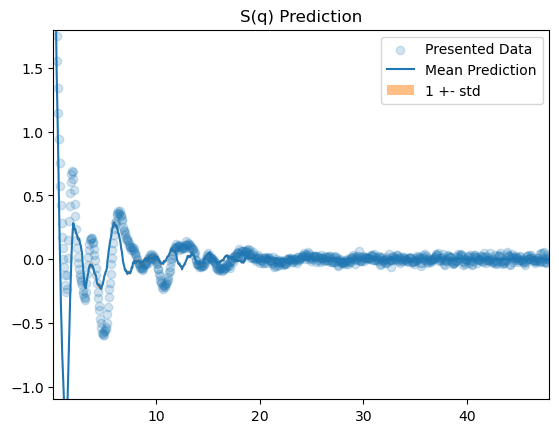

loss: -1121.930450  [   10/  100]
l:       0.114569 
max:     0.263580 
slope:   7.141098 
loc:     4.467903 
decay:   0.306038 
sigma_n: 0.022465 
r_0:     2.859055 
s:       26.343718 
h:   1.226389 
r:   1.287952 
s:   0.174447 
h:   0.921103 
r:   2.329928 
s:   0.176188 
h:   0.211741 
r:   2.729716 
s:   0.151978 
Minutes Taken Since Last Report: 60.268892 



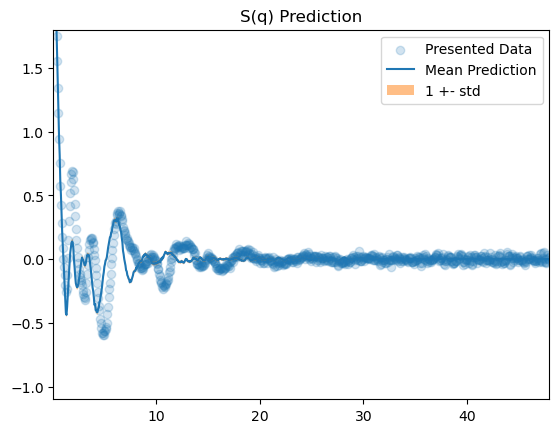

loss: -1079.206619  [   20/  100]
l:       0.157188 
max:     0.210897 
slope:   7.053078 
loc:     2.502894 
decay:   0.196655 
sigma_n: 0.032010 
r_0:     2.881969 
s:       26.000965 
h:   0.961511 
r:   1.277400 
s:   0.180522 
h:   0.764845 
r:   2.321576 
s:   0.180311 
h:   0.176425 
r:   2.731556 
s:   0.149936 
Minutes Taken Since Last Report: 62.672241 



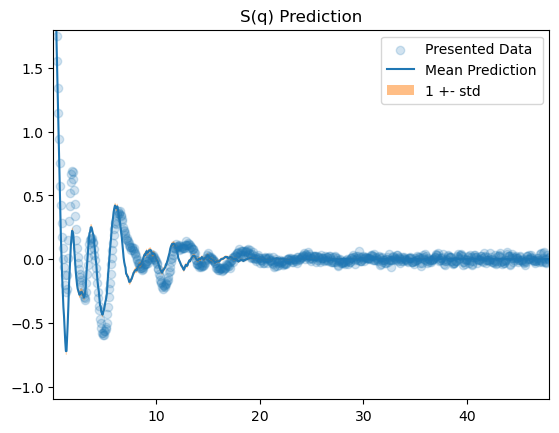

loss: -1094.253670  [   30/  100]
l:       0.154361 
max:     0.207781 
slope:   7.053465 
loc:     2.371394 
decay:   0.194641 
sigma_n: 0.030113 
r_0:     2.884192 
s:       25.837891 
h:   0.919104 
r:   1.273321 
s:   0.182710 
h:   0.781928 
r:   2.318063 
s:   0.182151 
h:   0.166178 
r:   2.731684 
s:   0.148350 
Minutes Taken Since Last Report: 52.791186 



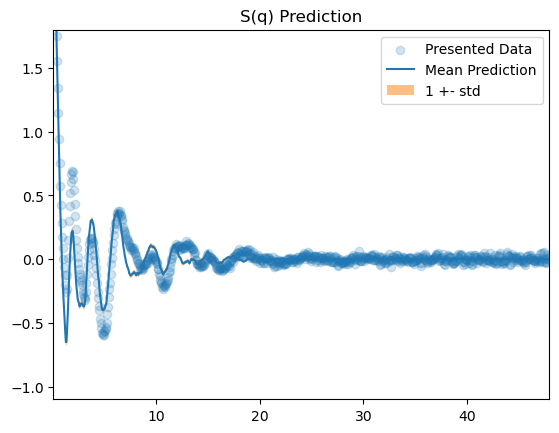

_LinAlgError: linalg.eigh: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 63639921).

In [6]:
optimizer = torch.optim.SGD(gp.parameters(), lr=0.0001, momentum=0.95)
train_loop(dataset_CH, gp, optimizer, 100, r_grid, q_train, partial_sq_noisey_CH, q_infer, r_infer, -1.1,1.8, -0.1,3.1)

In [ ]:
with torch.no_grad():
    gp.SAMPLE_COUNT = 20_000
    plt.title("S(q) Prediction")
    μ_q, Σ_q = gp.predict_sq_monte_carlo(r_grid, q_infer, q_train, partial_sq_noisey_CH, optimal_shrinkage=True)
    plt.scatter(q_train,partial_sq_noisey_CH,alpha=0.2,label="Presented Data")
    plt.plot(q_infer.detach().numpy(),μ_q.detach().numpy(),label="Mean Prediction")
    plt.fill_between(q_infer.T[0].detach().numpy(), μ_q.T[0].detach().numpy()+torch.diag(Σ_q).detach().numpy()**0.5, μ_q.T[0].detach().numpy()-torch.diag(Σ_q).detach().numpy()**0.5,alpha=0.5,label="1 +- std")
    plt.ylim(-1.1,1.8)
    plt.xlim(q_infer[0],q_infer[-1])
    plt.legend()
    plt.show()

In [ ]:
with torch.no_grad():
    plt.title("RDF Prediction")
    μ_r, Σ_r = gp.predict_rdf_monte_carlo(r_grid, r_infer, q_train, partial_sq_noisey_CH)
    plt.plot(r_infer.detach().numpy(),μ_r.detach().numpy(),label="Mean Prediction")
    plt.fill_between(r_infer.T[0].detach().numpy(), μ_r.T[0].detach().numpy()+torch.diag(Σ_r).detach().numpy()**0.5, μ_r.T[0].detach().numpy()-torch.diag(Σ_r).detach().numpy()**0.5,alpha=0.5,label="1 +- std")
    plt.ylim(ylo_r,yhi_r)
    plt.xlim(r_infer[0],r_infer[-1])
    plt.legend()
    plt.show()